# Проект Выбор локации для скважины
Исполнитель: Троицкий Илья  
Дата: 20 июня 2023  
Проект выполняется в рамках курса Data Science bootcamp, Спринт 11  

## Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Условия задачи
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

### Описание данных

Данные геологоразведки трёх регионов находятся в файлах:   
```
/datasets/geo_data_0.csv.  
/datasets/geo_data_1.csv.  
/datasets/geo_data_2.csv.  
```

`id` — уникальный идентификатор скважины;  
`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);  
`product` — объём запасов в скважине (тыс. баррелей).  

## Импорт библиотек и описание функций

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [2]:
def dataframe_info(df):
    display(df.head())
    print('SHAPE:', df.shape)
    df.info()
    print('DUPLICATES:', df.duplicated().sum())
    print(df.corr())
    df.boxplot(column=['f0','f1','f2'])
    plt.show()

def remove_outlier(data, col):
    q1 = data[col].quantile(0.25)   
    q3 = data[col].quantile(0.75)
    iqr = q3-q1

    min = q1 - iqr*1.5
    max = q3 + iqr*1.5

    return data.query(f'({col} > {min}) and ({col} < {max})')

## Загрузка и подготовка данных

In [3]:
try:
   r1_data = pd.read_csv('datasets/geo_data_0.csv')
   r2_data = pd.read_csv('datasets/geo_data_1.csv')
   r3_data = pd.read_csv('datasets/geo_data_2.csv')
except:
   r1_data = pd.read_csv('/datasets/geo_data_0.csv')
   r2_data = pd.read_csv('/datasets/geo_data_1.csv')
   r3_data = pd.read_csv('/datasets/geo_data_2.csv')      

колонка id - уникальный идентификатор скважины и для обучения она не нужна.

In [4]:
r1_data = r1_data.drop('id', axis=1)
r2_data = r2_data.drop('id', axis=1)
r3_data = r3_data.drop('id', axis=1)

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647


SHAPE: (100000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
DUPLICATES: 0
               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000


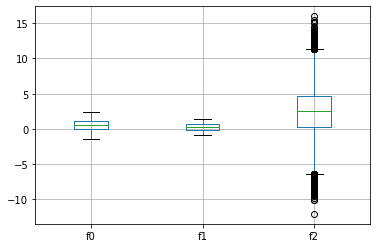

In [5]:
dataframe_info(r1_data)

Пропусков нет. Дублей нет. Есть слабая корреляция f2 и product. В признаке f2 обнаружено много выбросов, удалим эти строки из датасета.

In [6]:
r1_data = remove_outlier(r1_data, 'f2')
print(r1_data.shape)


(99494, 4)


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305


SHAPE: (100000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
DUPLICATES: 0
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000


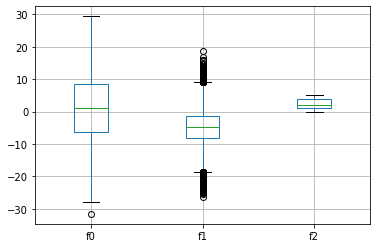

In [7]:
dataframe_info(r2_data)

 Пропусков нет. Дублей нет. Есть сильная корреляция f2 и product. В признаке f1 обнаружено много выбросов, удалим эти строки из датасета.

In [8]:
r2_data = remove_outlier(r2_data, 'f1')
print(r2_data.shape)

(99364, 4)


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746


SHAPE: (100000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
DUPLICATES: 0
               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000


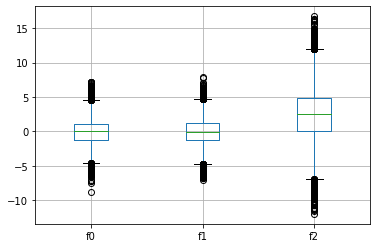

In [9]:
dataframe_info(r3_data)

 Пропусков нет. Дублей нет. Есть слабая корреляция f2 и product. Во всех трех признаках обнаружено много выбросов, удалим эти строки из датасета.


In [10]:
r3_data = remove_outlier(r3_data, 'f0')
r3_data = remove_outlier(r3_data, 'f1')
r3_data = remove_outlier(r3_data, 'f2')
print(r2_data.shape)

(99364, 4)


### Вывод
Данные не содержат пропусков и дублей. Признаки имеют тип вещественного числа и требуют масштабирования. Выбросы в данных обработаны. В данных по первому и третьему региону есть слабая зависимость целевого признака от признака f2. Во втором регионе зависимость целевого признака от ф2 прямая.

## Обучение и проверка модели

In [11]:
numeric_features = ['f0','f1','f2']  # список числовых переменных

def data_split(data):
    x = data.drop('product', axis=1)
    y = data['product']

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=31337)

    return x_train, x_valid, y_train, y_valid

def model_fit(x, y):

    numeric_transformer = StandardScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, x.columns),
        ])


    model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

    model.fit(x, y)

    return model

def model_fit_predict(data):

    x_train, x_valid, y_train, y_valid = data_split(data)

    model = model_fit(x_train, y_train)

    result = {
        'model' : model,
        'y_valid' : y_valid,
        'y_pred' : model.predict(x_valid)
    }
    
    return result

In [12]:
r1 = model_fit_predict(r1_data)

print('Cредний запас предсказанного сырья:', r1['y_pred'].mean())
print('RMSE:', mean_squared_error(r1['y_valid'], r1['y_pred'])**0.5)

Cредний запас предсказанного сырья: 92.27388735933118
RMSE: 37.601229107972486


In [13]:
r2 = model_fit_predict(r2_data)

print('Cредний запас предсказанного сырья:', r2['y_pred'].mean())
print('RMSE:', mean_squared_error(r2['y_valid'], r2['y_pred'])**0.5)

Cредний запас предсказанного сырья: 68.6956533353401
RMSE: 0.8908500430599684


In [14]:
r3 = model_fit_predict(r3_data)

print('Cредний запас предсказанного сырья:', r3['y_pred'].mean())
print('RMSE:', mean_squared_error(r3['y_valid'], r3['y_pred'])**0.5)

Cредний запас предсказанного сырья: 94.57894982190793
RMSE: 39.96381769894487


### Вывод
В регионе 1 и 3 средние предсказанные запасы сырья выше, но ошибка предсказаний тоже выше. Во втором регионе ситуация обратная, средний предсказанный запас ниже чем в остальнных, но точность предсказания очень высокая

## Подготовка к расчёту прибыли

Создадим константы, по условиям задачи, чтобы в случае изменения ТЗ можно было изменить только в одном мест 

In [15]:
BUDGET_AMOUNT = 10000000000
TEST_POINTS = 500
DEV_POINTS = 200
PRICE_PER_BARREL = 450000
RISK_THRESHOLD =  0.025

Рассчитаем объем сырья для окупаемости затрат.

In [16]:
product_value = BUDGET_AMOUNT / (PRICE_PER_BARREL * DEV_POINTS)
print(product_value)

111.11111111111111


### Вывод
Объём сырья для безубыточной разработки новой скважины равен 111.11 тысячам баррелей, а средний объем сырья в скважинах: Регион 1 и 3 ~92 тыч. бар. А в регионе 2 вообще 68 тыс. бар. Но так как из 500 текстиовых скважин будем брать только лучшие 200, то возможно мы приблизимся к точке окупаемости.

## Расчёт прибыли и рисков 

Функция для расчета прибыли

In [17]:
def revenue(target, pred):
    pred = pd.Series(pred)
    probs_sorted = pred.sort_values(ascending=False)
    target = target.reset_index(drop=True)
    selected = target[probs_sorted.index][:DEV_POINTS]
    return PRICE_PER_BARREL * selected.sum() - BUDGET_AMOUNT

Протестируем её на предсказанных ранее данных

In [18]:
print('Прибыль на региона 1: ', revenue(r1['y_valid'], r1['y_pred']))
print('Прибыль на региона 2: ', revenue(r2['y_valid'], r2['y_pred']))
print('Прибыль на региона 3: ', revenue(r3['y_valid'], r3['y_pred']))

Прибыль на региона 1:  2987946454.8754177
Прибыль на региона 2:  2415086696.681511
Прибыль на региона 3:  2466186982.774006


Шансы есть! Только у нас в валидационной выборке ~2500 скважин, а тестировать будем всего 500.

Применяем технику boostrap для поиска распределния прибыли

In [19]:
state = np.random.RandomState(31337)

def bootstrap_prediction(data, model):
    values = []

    for i in range(1000):
        subsample = data.sample(500, replace=True, random_state=state)
        x = subsample.drop('product', axis=1)
        y = subsample['product']
        y_pred = model.predict(x)
        
        values.append(revenue(y, y_pred))

    values = pd.Series(values)
    lower = round(values.quantile(0.025) / 1000000, 2)
    upper = round(values.quantile(0.975) / 1000000, 2)
    mean = values.mean() 

    print('Средняя прибыль (млн. руб.):', round(mean  / 1000000, 2))
    print(f'95% доверительный интервал (млн. руб.): {lower}-{upper}')
    print('Риск убытков:', round(values[values<0].count() / values.count() * 100, 2))
    print('ROI (сред):', round(mean / BUDGET_AMOUNT * 100, 2))

In [20]:
bootstrap_prediction(r1_data, r1['model'])

Средняя прибыль (млн. руб.): 418.94
95% доверительный интервал (млн. руб.): -108.04-887.75
Риск убытков: 6.4
ROI (сред): 4.19


In [21]:
bootstrap_prediction(r2_data, r2['model'])

Средняя прибыль (млн. руб.): 453.82
95% доверительный интервал (млн. руб.): 72.38-855.89
Риск убытков: 1.1
ROI (сред): 4.54


In [22]:
bootstrap_prediction(r3_data, r3['model'])

Средняя прибыль (млн. руб.): 329.02
95% доверительный интервал (млн. руб.): -173.92-867.46
Риск убытков: 10.7
ROI (сред): 3.29


## Вывод
Выполнили анализ данных о скважинах в трёх регионах. Данные были очищены от аномалий. Для каждого региона построена прогнозная модель, предсказывающая запасы сырья в регионе. 
В результате анализа мы выяснили, что регион №2 имеет риск убытков ниже требуемого в 2,5%. и обладает самым высоким ROI. Хотя в целом ROI у всех регионов довольно низкая, возможно стоит рассмотреть альтернативные источники ивестирования, например обучение сотрудников Data Science.